# Malignant or Benign Training

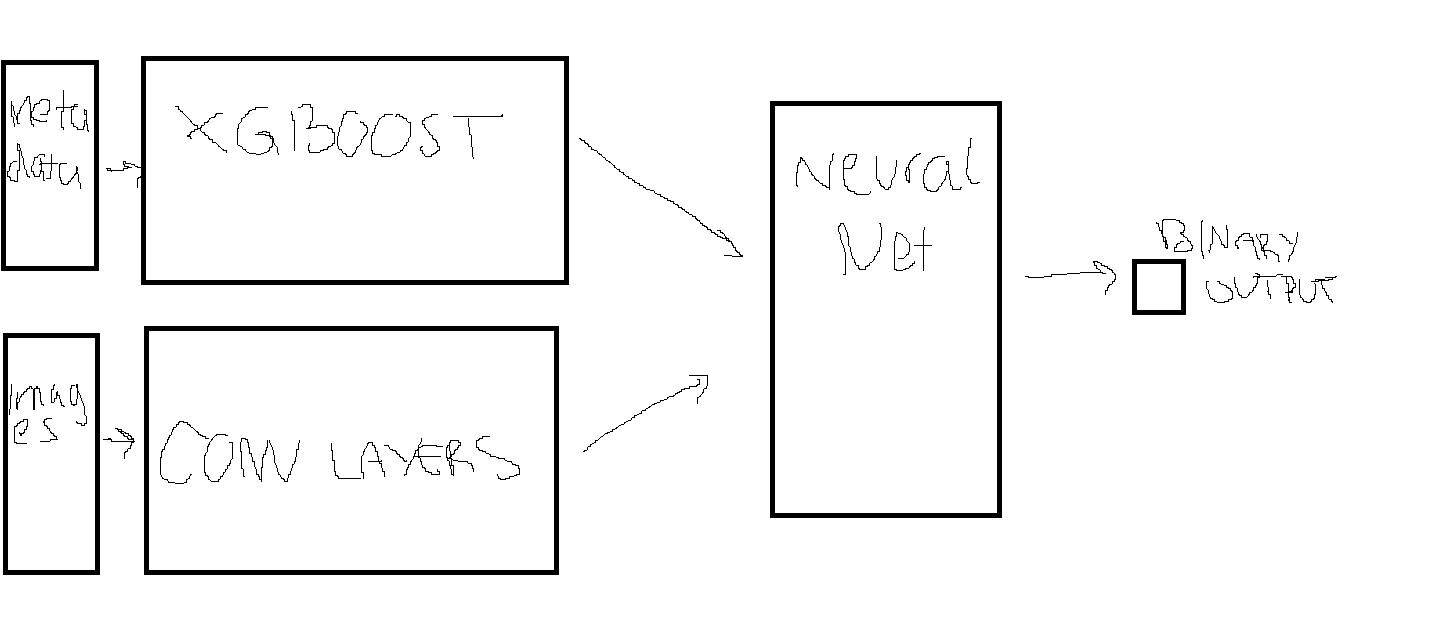

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers # Might have just abandoned this 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, accuracy_score  # Import accuracy_score for da training process
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
import concurrent.futures
from catboost import CatBoostClassifier

import h5py 
import matplotlib.pyplot as plt # For graphing/ viewing the images stored
import numpy as np # Used a numpy array to store resized images 
from PIL import Image
import io
from xgboost import XGBRegressor
import os
import sqlite3

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

2025-03-22 15:07:33.408018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 15:07:33.408166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 15:07:33.572953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


In [2]:
training_meta_data = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
testing_meta_data = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
print('done')

/tmp/ipykernel_24/2859553381.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  training_meta_data = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


done


In [3]:
training_meta_data.head(2)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.47617,0.0,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.0,9.307003,0.0,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.23529,0.0,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.0,3.354148,0.0,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


In [4]:
# Okay today we are splitting the benign data into two sets randomly, so we can have two whole models trained seperately and combine to give a prediction

meta_malignant_cases = training_meta_data[training_meta_data['target'] == 1]
meta_benign_cases = training_meta_data[training_meta_data['target'] == 0]
meta_malignant_cases.shape

(393, 55)

In [5]:
# So we will split the benign data seperately from the malingant data, becuase there is so little of it we just make both models learn of this small
# set of malignasnt cases
print(meta_benign_cases.shape)
benign_cases_split_1, benign_cases_split_2 = train_test_split(meta_benign_cases, test_size=0.4, random_state=42)
benign_cases_split_2, benign_cases_split_3 = train_test_split(benign_cases_split_2, test_size=0.5, random_state=42)
benign_cases_split_2, benign_cases_split_4 = train_test_split(benign_cases_split_2, test_size=0.5, random_state=42)
benign_cases_split_3, benign_cases_split_5 = train_test_split(benign_cases_split_3, test_size=0.5, random_state=42)

print(benign_cases_split_1.shape) # For the main model in the ensemble
print(benign_cases_split_2.shape) # For the lone xgboost
print(benign_cases_split_3.shape) # For the lone cnn
print(benign_cases_split_4.shape) # For the lone catboost
print(benign_cases_split_5.shape) # For the lone catboost



# Then we combine them again so now we have two large training sets for two seperate models. Its go time baybee
training_meta_data_1 = pd.concat([meta_malignant_cases, benign_cases_split_1], axis=0)
training_meta_data_2 = pd.concat([meta_malignant_cases, benign_cases_split_2], axis=0)
training_meta_data_3 = pd.concat([meta_malignant_cases, benign_cases_split_3], axis=0)
training_meta_data_4 = pd.concat([meta_malignant_cases, benign_cases_split_4], axis=0)
training_meta_data_5 = pd.concat([meta_malignant_cases, benign_cases_split_5], axis=0)
print('==========================================')
print(training_meta_data_1.shape) # For the main model in the ensemble
print(training_meta_data_2.shape) # For the lone xgboost
print(training_meta_data_3.shape) # For the lone cnn
print(training_meta_data_4.shape) # For the lone catboost
print(training_meta_data_5.shape) # Maybe for the final nerual head 

(400666, 55)
(240399, 55)
(40066, 55)
(40067, 55)
(40067, 55)
(40067, 55)
(240792, 55)
(40459, 55)
(40460, 55)
(40460, 55)
(40460, 55)


Now the idea is we dont need to change anythign about the image data, since we sort uusing ids, we will have two seperate  sql queries, two seperate instances of feature engineering, two serpeaste xgboosts and two sperate cnns, 

## Read train Images

### Get images and resize them from the HDF5 file

In [6]:
# Here we shall get the images and ids from the HDF5 file containing this stuff, also lets resize all the iamges while we are at it

def load_image(id, f):
    image_data = f[id][()]  # Extract the image data
    return (id, image_data)

# Initialize an empty list to store the data and we will put it in a df later
training_image_data = []

with h5py.File('/kaggle/input/isic-2024-challenge/train-image.hdf5', 'r') as f:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_image, id, f) for id in f.keys()]
        for future in concurrent.futures.as_completed(futures):
            training_image_data.append(future.result())


# Convert the list to a DataFrame
training_image_data = pd.DataFrame(training_image_data, columns=['isic_id', 'image_data'])


print(training_image_data.shape)


(401059, 2)


## SQL Query for ids

### SQL for training set 1

In [7]:

# SQLITE so we shall collect only the ids which have meta data AND image data  

conn = sqlite3.connect(':memory:')

# Write the DataFrame to the SQLite database
training_meta_data_1['isic_id'].to_sql('training_meta_data_1', conn, index=False, if_exists='replace')
training_image_data['isic_id'].to_sql('training_image_data', conn, index=False, if_exists='replace')

# Perform SQL queries
query = """
SELECT p.isic_id
FROM `training_meta_data_1` AS p 
INNER JOIN `training_image_data` AS o
    ON p.isic_id = o.isic_id
ORDER BY p.isic_id
"""
training_ids_1 = pd.read_sql_query(query, conn)

# Lets sort all the ids in order so when we are creating training and val sets for meta/image data, the entries are matching and in order
training_ids_1 = training_ids_1.sort_values(by='isic_id', ascending=False)

# Display the result
training_ids_1.shape


(240792, 1)

### SQL for XGBOOST 2 training set

In [8]:

# # SQLITE so we shall collect only the ids which have meta data AND image data  

# # Write the DataFrame to the SQLite database
# training_meta_data_2['isic_id'].to_sql('training_meta_data_2', conn, index=False, if_exists='replace')
# training_image_data['isic_id'].to_sql('training_image_data', conn, index=False, if_exists='replace')

# # Perform SQL queries
# query = """
# SELECT p.isic_id
# FROM `training_meta_data_2` AS p 
# INNER JOIN `training_image_data` AS o
#     ON p.isic_id = o.isic_id
# ORDER BY p.isic_id
# """
# training_ids_2 = pd.read_sql_query(query, conn)

# # Lets sort all the ids in order so when we are creating training and val sets for meta/image data, the entries are matching and in order
# training_ids_2 = training_ids_2.sort_values(by='isic_id', ascending=False)

# # Display the result
# training_ids_2.shape

### SQL for CNN 2 training set

In [9]:
# SQLITE so we shall collect only the ids which have meta data AND image data  

# Write the DataFrame to the SQLite database
training_meta_data_3['isic_id'].to_sql('training_meta_data_3', conn, index=False, if_exists='replace')
training_image_data['isic_id'].to_sql('training_image_data', conn, index=False, if_exists='replace')

# Perform SQL queries
query = """
SELECT p.isic_id
FROM `training_meta_data_3` AS p 
INNER JOIN `training_image_data` AS o
    ON p.isic_id = o.isic_id
ORDER BY p.isic_id
"""
training_ids_3 = pd.read_sql_query(query, conn)

# Lets sort all the ids in order so when we are creating training and val sets for meta/image data, the entries are matching and in order
training_ids_3 = training_ids_3.sort_values(by='isic_id', ascending=False)

# Display the result
training_ids_3.shape

(40460, 1)

### SQL for final neural head training set

In [10]:
# SQLITE so we shall collect only the ids which have meta data AND image data  

# Write the DataFrame to the SQLite database
training_meta_data_5['isic_id'].to_sql('training_meta_data_5', conn, index=False, if_exists='replace')
training_image_data['isic_id'].to_sql('training_image_data', conn, index=False, if_exists='replace')

# Perform SQL queries
query = """
SELECT p.isic_id
FROM `training_meta_data_5` AS p 
INNER JOIN `training_image_data` AS o
    ON p.isic_id = o.isic_id
ORDER BY p.isic_id
"""
training_ids_5 = pd.read_sql_query(query, conn)

# Lets sort all the ids in order so when we are creating training and val sets for meta/image data, the entries are matching and in order
training_ids_5 = training_ids_5.sort_values(by='isic_id', ascending=False)

# Display the result
training_ids_5.shape

(40460, 1)

Now we split training set 1 and 2 into thier training and val sets

In [11]:
# This is where we split the ids into trainig and validation sets

train_ids_1, val_ids_1 = train_test_split(training_ids_1['isic_id'], test_size=0.2, random_state=42)
print(train_ids_1.shape) # training set of ids 
print(val_ids_1.shape) # Val set of ids
print(train_ids_1.head(2)) # first two entries of training ids

(192633,)
(48159,)
108576    ISIC_4557061
40325     ISIC_1730971
Name: isic_id, dtype: object


In [12]:

train_ids_3, val_ids_3 = train_test_split(training_ids_3['isic_id'], test_size=0.2, random_state=42)
print(train_ids_3.shape) # training set of ids 
print(val_ids_3.shape) # Val set of ids
print(train_ids_3.head(2)) # first two entries of training ids

(32368,)
(8092,)
8331    ISIC_2123434
2396    ISIC_0669651
Name: isic_id, dtype: object


In [13]:
train_ids_5, val_ids_5 = train_test_split(training_ids_5['isic_id'], test_size=0.2, random_state=42)
print(train_ids_5.shape) # training set of ids 
print(val_ids_5.shape) # Val set of ids
print(train_ids_5.head(2)) # first two entries of training ids

(32368,)
(8092,)
8331    ISIC_2122603
2396    ISIC_0657164
Name: isic_id, dtype: object


### Now we use the train and val ids to get the actual train and val entries, but SEPERATELY for both training set 1 and 2

In [14]:
# Use the split training and val id sets to split meta data and image data into training and validation sets)

meta_train_1 = training_meta_data_1[training_meta_data_1['isic_id'].isin(train_ids_1)]  
meta_val_1 = training_meta_data_1[training_meta_data_1['isic_id'].isin(val_ids_1)]
image_train_1 = training_image_data[training_image_data['isic_id'].isin(train_ids_1)] 
image_val_1 = training_image_data[training_image_data['isic_id'].isin(val_ids_1)]
print(meta_train_1.shape)
print(image_train_1.shape)

(192633, 55)
(192633, 2)


In [15]:
# Use the split training and val id sets to split meta data and image data into training and validation sets) wE DO NOT NEED IMAGE DATA FOR THIS ONE

# meta_train_2 = training_meta_data_2[training_meta_data_2['isic_id'].isin(train_ids_2)]  
# meta_val_2 = training_meta_data_2[training_meta_data_2['isic_id'].isin(val_ids_2)]
# image_train_2 = training_image_data[training_image_data['isic_id'].isin(train_ids_2)]
# image_val_2 = training_image_data[training_image_data['isic_id'].isin(val_ids_2)]

meta_train_2, meta_val_2 = train_test_split(training_meta_data_2, test_size=0.2, random_state=42)

print(meta_train_2.shape)
# print(image_train_2.shape)

(32367, 55)


In [16]:
# Use the split training and val id sets to split meta data and image data into training and validation sets) Still using meta data cos I use this to 
# retrieve the target

meta_train_3 = training_meta_data_3[training_meta_data_3['isic_id'].isin(train_ids_3)]  
meta_val_3 = training_meta_data_3[training_meta_data_3['isic_id'].isin(val_ids_3)]
image_train_3 = training_image_data[training_image_data['isic_id'].isin(train_ids_3)]
image_val_3 = training_image_data[training_image_data['isic_id'].isin(val_ids_3)]
# print(meta_train_3.shape)
print(image_train_3.shape)

(32368, 2)


In [17]:
meta_train_4, meta_val_4 = train_test_split(training_meta_data_4, test_size=0.2, random_state=42)

print(meta_train_4.shape)
# print(image_train_4.shape)

(32368, 55)


In [18]:
meta_train_5 = training_meta_data_5[training_meta_data_5['isic_id'].isin(train_ids_5)]  
meta_val_5 = training_meta_data_5[training_meta_data_5['isic_id'].isin(val_ids_5)]
image_train_5 = training_image_data[training_image_data['isic_id'].isin(train_ids_5)] 
image_val_5 = training_image_data[training_image_data['isic_id'].isin(val_ids_5)]
print(meta_train_5.shape)
print(image_train_5.shape)

(32368, 55)
(32368, 2)


In [19]:
print(meta_train_1.shape) ## Now we can see yes it has been split into train and val sets, and the train and val sets should be identical 
print(meta_val_1.shape)
print(image_train_1.shape)
print(image_val_1.shape)
print('-------------------------------------')
print(meta_train_2.shape) 
print(meta_val_2.shape)
print('-------------------------------------')
print(image_train_3.shape)
print(image_val_3.shape)
print('-------------------------------------')
print(image_train_5.shape)
print(image_val_5.shape)

(192633, 55)
(48159, 55)
(192633, 2)
(48159, 2)
-------------------------------------
(32367, 55)
(8092, 55)
-------------------------------------
(32368, 2)
(8092, 2)
-------------------------------------
(32368, 2)
(8092, 2)


## Feature Engineering of meta data

In [20]:
# Features I want to mess with

features = ['target','sex', 'age_approx','clin_size_long_diam_mm','tbp_tile_type','tbp_lv_A','tbp_lv_Aext','tbp_lv_B','tbp_lv_Bext',
           'tbp_lv_C','tbp_lv_Cext','tbp_lv_H','tbp_lv_Hext','tbp_lv_L','tbp_lv_Lext','tbp_lv_areaMM2','tbp_lv_area_perim_ratio',
            'tbp_lv_color_std_mean','tbp_lv_deltaA','tbp_lv_deltaB','tbp_lv_deltaL','tbp_lv_deltaLBnorm','tbp_lv_eccentricity',
            'tbp_lv_location','tbp_lv_minorAxisMM','tbp_lv_nevi_confidence','tbp_lv_norm_border','tbp_lv_norm_color',
            'tbp_lv_perimeterMM','tbp_lv_radial_color_std_max','tbp_lv_stdL','tbp_lv_stdLExt','tbp_lv_symm_2axis','tbp_lv_symm_2axis_angle',
           'tbp_lv_x','tbp_lv_y','tbp_lv_z']

meta_train_df_1 = meta_train_1[features]
meta_val_df_1 = meta_val_1[features]
#  Now for training set 2 (XGBOOST)
meta_train_df_2 = meta_train_2[features]
meta_val_df_2 = meta_val_2[features]
#  Now for training set 4 (CATBOOST)
meta_train_df_4 = meta_train_4[features]
meta_val_df_4 = meta_val_4[features]
#  Now for training set 5 (Final HEAD)
meta_train_df_5 = meta_train_5[features]
meta_val_df_5 = meta_val_5[features]
print('done')

done


In [21]:
print(meta_train_df_1.shape)
print(meta_val_df_1.shape)

(192633, 37)
(48159, 37)


In [22]:
print(meta_train_df_2.shape)
print(meta_val_df_2.shape)

(32367, 37)
(8092, 37)


In [23]:
print(meta_train_df_4.shape)
print(meta_val_df_4.shape)

(32368, 37)
(8092, 37)


In [24]:
print(meta_train_df_5.shape)
print(meta_val_df_5.shape)

(32368, 37)
(8092, 37)


### Feature engineering function to modify features in train and val sets

In [25]:

## This shall edit the features the same way in both training and validation sets


def feature_engineer(dataset, training_columns=None):
    # Fill NaN values with a placeholder
    dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
    dataset['age_approx'].fillna(dataset['age_approx'].mean(), inplace=True) # Fill unknown ages with mean age 

    
    columns = ['sex', 'tbp_tile_type', 'tbp_lv_location']  # Columns to be one-hot encoded
    dataset = pd.get_dummies(dataset, columns=columns)
    
     # Normalize all columns except the target AND one hot encoded columns (Dont want to affect the one hot encoded ones)
    target_col = 'target'  # Replace with your actual target column name
    feature_cols = [col for col in dataset.columns if col != target_col and dataset[col].dtype != 'bool']
    scaler = MinMaxScaler()
    dataset[feature_cols] = scaler.fit_transform(dataset[feature_cols])
    
    # For all one hot encoded columns, turn into binary columns
    for column in dataset.select_dtypes(include=['bool']).columns: 
        dataset[column] = dataset[column].astype(int)

    
    # Just making sure this is int type    
    dataset['age_approx'] = dataset['age_approx'].astype(int) # Convert ages into int types
    
    # If training_columns is provided, reindex the dataset to ensure it has the same columns
    if training_columns is not None:
        dataset = dataset.reindex(columns=training_columns, fill_value=0)
        
    
    return dataset

print('done')

training_columns = feature_engineer(meta_train_1[features]).columns


done


/tmp/ipykernel_24/894760655.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/894760655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/894760655.py:7: F

In [26]:

meta_train_df_1 = feature_engineer(meta_train_df_1, training_columns=training_columns)
meta_val_df_1 = feature_engineer(meta_val_df_1, training_columns=training_columns)
#  Also for training set 2 (XGBOOST)
meta_train_df_2 = feature_engineer(meta_train_df_2, training_columns=training_columns)
meta_val_df_2 = feature_engineer(meta_val_df_2, training_columns=training_columns)
#  Also for training set 4 (CATBOOST)
meta_train_df_4 = feature_engineer(meta_train_df_4, training_columns=training_columns)
meta_val_df_4 = feature_engineer(meta_val_df_4, training_columns=training_columns)
#  Also for training set 4 (Final HEAD)
meta_train_df_5 = feature_engineer(meta_train_df_5, training_columns=training_columns)
meta_val_df_5 = feature_engineer(meta_val_df_5, training_columns=training_columns)

/tmp/ipykernel_24/894760655.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/894760655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/894760655.py:7: F

In [27]:
print(meta_train_df_1.shape) # We can see yes the split train and validation sets are still split, and have more columns
print(meta_val_df_1.shape)
print('---------------')
print(meta_train_df_2.shape) # XGBOOST
print(meta_val_df_2.shape)
print('---------------')
print(meta_train_df_4.shape) # CATBOOST
print(meta_val_df_4.shape)
print('---------------')
print(meta_train_df_5.shape) # Final HEAD
print(meta_val_df_5.shape)

(192633, 60)
(48159, 60)
---------------
(32367, 60)
(8092, 60)
---------------
(32368, 60)
(8092, 60)
---------------
(32368, 60)
(8092, 60)


In [28]:
meta_train_df_1.head(1)

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,sex_Unknown,sex_female,sex_male,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_Head & Neck,tbp_lv_location_Left Arm,tbp_lv_location_Left Arm - Lower,tbp_lv_location_Left Arm - Upper,tbp_lv_location_Left Leg,tbp_lv_location_Left Leg - Lower,tbp_lv_location_Left Leg - Upper,tbp_lv_location_Right Arm,tbp_lv_location_Right Arm - Lower,tbp_lv_location_Right Arm - Upper,tbp_lv_location_Right Leg,tbp_lv_location_Right Leg - Lower,tbp_lv_location_Right Leg - Upper,tbp_lv_location_Torso Back,tbp_lv_location_Torso Back Bottom Third,tbp_lv_location_Torso Back Middle Third,tbp_lv_location_Torso Back Top Third,tbp_lv_location_Torso Front,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown
387,1,0,0.327914,0.36978,0.480132,0.321112,0.295493,0.4173,0.307608,0.494239,0.292094,0.230086,0.21116,0.142527,0.223937,0.394868,0.425782,0.472352,0.740822,0.339794,0.777134,0.386477,0.00016,0.568197,0.983058,0.355937,0.343175,0.328967,0.083571,0.454394,0.0,0.540113,0.759256,0.34993,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Smote time hopefully

In [29]:
X = meta_train_df_2.drop(columns=['target'])  # Assuming 'target' is the column you want to predict
y = meta_train_df_2['target']


smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

meta_train_df_2_resampled = pd.DataFrame(X_resampled, columns=X.columns)
meta_train_df_2_resampled['target'] = y_resampled

print(meta_train_df_2_resampled.shape)
meta_train_df_2_resampled.target.value_counts()

(54495, 60)


target
0    32056
1    22439
Name: count, dtype: int64

## XGBoost

In [30]:
# Now its boosting time
# Get the x and y's of both training and validation sets
X_meta_train_1 = meta_train_df_1.drop(['target'], axis=1)
y_meta_train_1 = meta_train_df_1['target']


X_meta_val_1 = meta_val_df_1.drop(['target'], axis=1)
y_meta_val_1 = meta_val_df_1['target']


# Now for training set 2

X_meta_train_2 = meta_train_df_2_resampled.drop(['target'], axis=1)
y_meta_train_2 = meta_train_df_2_resampled['target']


X_meta_val_2 = meta_train_df_2_resampled.drop(['target'], axis=1)
y_meta_val_2 = meta_train_df_2_resampled['target']


# For the Final head 
X_meta_train_5 = meta_train_df_5.drop(['target'], axis=1)
y_meta_train_5 = meta_train_df_5['target']


X_meta_val_5 = meta_val_df_5.drop(['target'], axis=1)
y_meta_val_5 = meta_val_df_5['target']

print('done')

done


### Xgboost model 1

In [31]:

boost_model_1 = XGBRegressor(objective='binary:logistic', device='cuda', reg_lambda=0.1,tree_method='hist', alpha=0.1) # Define the xgboost

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation
# cv_scores_1 = cross_val_score(boost_model_1, X_meta_train_1, y_meta_train_1, cv=skf, scoring='roc_auc', verbose=True)

# # Print cross-validation scores
# print(f'Cross-validation scores: {cv_scores_1}')
# print(f'Mean CV score: {cv_scores_1.mean()}')

In [32]:

boost_model_1.fit(
    X_meta_train_1, y_meta_train_1, 
    eval_set=[(X_meta_val_1, y_meta_val_1)], 
    early_stopping_rounds=2, 
    verbose=True 
)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.09662
[1]	validation_0-logloss:0.07219
[2]	validation_0-logloss:0.05471
[3]	validation_0-logloss:0.04209
[4]	validation_0-logloss:0.03303
[5]	validation_0-logloss:0.02637
[6]	validation_0-logloss:0.02157
[7]	validation_0-logloss:0.01805
[8]	validation_0-logloss:0.01573
[9]	validation_0-logloss:0.01389
[10]	validation_0-logloss:0.01253
[11]	validation_0-logloss:0.01156
[12]	validation_0-logloss:0.01097
[13]	validation_0-logloss:0.01053
[14]	validation_0-logloss:0.01021
[15]	validation_0-logloss:0.00995
[16]	validation_0-logloss:0.00983
[17]	validation_0-logloss:0.00980
[18]	validation_0-logloss:0.00981
[19]	validation_0-logloss:0.00972
[20]	validation_0-logloss:0.00972
[21]	validation_0-logloss:0.00976


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

### Xgboost model 2

In [33]:
boost_model_2 = XGBRegressor(objective='binary:logistic', device='cuda', reg_lambda=0.1,tree_method='hist', alpha=0.1) # Define the xgboost


# # Perform cross-validation
# cv_scores_2 = cross_val_score(boost_model_2, X_meta_train_2, y_meta_train_2, cv=skf, scoring='roc_auc', verbose=True)

# # Print cross-validation scores
# print(f'Cross-validation scores: {cv_scores_2}')
# print(f'Mean CV score: {cv_scores_2.mean()}')

In [34]:
boost_model_2.fit(
    X_meta_train_2, y_meta_train_2, 
    eval_set=[(X_meta_val_2, y_meta_val_2)], 
    early_stopping_rounds=2, 
    verbose=True
)

[0]	validation_0-logloss:0.50488
[1]	validation_0-logloss:0.40792
[2]	validation_0-logloss:0.34515
[3]	validation_0-logloss:0.29865
[4]	validation_0-logloss:0.26517
[5]	validation_0-logloss:0.23873
[6]	validation_0-logloss:0.21612
[7]	validation_0-logloss:0.19920
[8]	validation_0-logloss:0.18769
[9]	validation_0-logloss:0.17519
[10]	validation_0-logloss:0.16680
[11]	validation_0-logloss:0.15756
[12]	validation_0-logloss:0.15024
[13]	validation_0-logloss:0.14181
[14]	validation_0-logloss:0.13648
[15]	validation_0-logloss:0.13220
[16]	validation_0-logloss:0.12421
[17]	validation_0-logloss:0.11694
[18]	validation_0-logloss:0.11315
[19]	validation_0-logloss:0.10824
[20]	validation_0-logloss:0.10303
[21]	validation_0-logloss:0.09693
[22]	validation_0-logloss:0.09458
[23]	validation_0-logloss:0.09292
[24]	validation_0-logloss:0.09014
[25]	validation_0-logloss:0.08797
[26]	validation_0-logloss:0.08648
[27]	validation_0-logloss:0.08251
[28]	validation_0-logloss:0.07941
[29]	validation_0-loglos

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-logloss:0.07087
[32]	validation_0-logloss:0.07034
[33]	validation_0-logloss:0.06740
[34]	validation_0-logloss:0.06386
[35]	validation_0-logloss:0.06121
[36]	validation_0-logloss:0.05913
[37]	validation_0-logloss:0.05666
[38]	validation_0-logloss:0.05577
[39]	validation_0-logloss:0.05246
[40]	validation_0-logloss:0.05195
[41]	validation_0-logloss:0.05104
[42]	validation_0-logloss:0.04877
[43]	validation_0-logloss:0.04793
[44]	validation_0-logloss:0.04675
[45]	validation_0-logloss:0.04572
[46]	validation_0-logloss:0.04405
[47]	validation_0-logloss:0.04306
[48]	validation_0-logloss:0.04180
[49]	validation_0-logloss:0.04082
[50]	validation_0-logloss:0.04032
[51]	validation_0-logloss:0.03896
[52]	validation_0-logloss:0.03743
[53]	validation_0-logloss:0.03648
[54]	validation_0-logloss:0.03591
[55]	validation_0-logloss:0.03526
[56]	validation_0-logloss:0.03508
[57]	validation_0-logloss:0.03410
[58]	validation_0-logloss:0.03299
[59]	validation_0-logloss:0.03197
[60]	validatio

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

## CatBoost

In [35]:
X_meta_train_4 = meta_train_df_4.drop(['target'], axis=1)
y_meta_train_4 = meta_train_df_4['target']


X_meta_val_4 = meta_val_df_4.drop(['target'], axis=1)
y_meta_val_4 = meta_val_df_4['target']


In [36]:
catboost_model = CatBoostClassifier(iterations=500, depth=15, learning_rate=0.1, loss_function='Logloss', task_type="GPU",)


In [37]:
catboost_model.fit(
    X_meta_train_4, y_meta_train_4, 
    eval_set=[(X_meta_val_4, y_meta_val_4)], 
    early_stopping_rounds=2, 
    verbose=True
)

0:	learn: 0.4711337	test: 0.4790973	best: 0.4790973 (0)	total: 1.64s	remaining: 13m 36s
1:	learn: 0.3217296	test: 0.3304818	best: 0.3304818 (1)	total: 1.73s	remaining: 7m 12s
2:	learn: 0.2294263	test: 0.2366743	best: 0.2366743 (2)	total: 2.43s	remaining: 6m 42s
3:	learn: 0.1577820	test: 0.1952904	best: 0.1952904 (3)	total: 2.81s	remaining: 5m 48s
4:	learn: 0.1209061	test: 0.1502403	best: 0.1502403 (4)	total: 2.95s	remaining: 4m 52s
5:	learn: 0.0984395	test: 0.1232686	best: 0.1232686 (5)	total: 3.17s	remaining: 4m 21s
6:	learn: 0.0798638	test: 0.1113324	best: 0.1113324 (6)	total: 3.31s	remaining: 3m 53s
7:	learn: 0.0666828	test: 0.1016869	best: 0.1016869 (7)	total: 3.53s	remaining: 3m 37s
8:	learn: 0.0573760	test: 0.0934701	best: 0.0934701 (8)	total: 13.3s	remaining: 12m 5s
9:	learn: 0.0515642	test: 0.0829841	best: 0.0829841 (9)	total: 23.1s	remaining: 18m 51s
10:	learn: 0.0471958	test: 0.0752693	best: 0.0752693 (10)	total: 33s	remaining: 24m 26s
11:	learn: 0.0424333	test: 0.0728424	bes

## Convolutional layers

### Prepare images for training using Image generator


In [38]:
# This is an image generator to feed batches of images into the training loop, seeing as it destroyed memory usage the other way 

def image_data_generator(image_series, label_series, batch_size, target_size):
    num_samples = len(image_series)
    while True:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_images = image_series[offset:offset + batch_size]
            batch_labels = label_series[offset:offset + batch_size]

            images = []
            for image in batch_images:
                image = np.array(Image.open(io.BytesIO(image))) # Take image as numpy array
                image = np.array(image, dtype='float32')  # Ensure correct data type
                image = tf.image.resize(image, target_size)
                images.append(image)

            # Normalize pixel values if needed
            images = np.array(images) / 255.0
            labels = np.array(batch_labels)

            yield images, labels

print('done')

done


In [39]:
# Get the x and y's of both training and validation sets

X_image_train_1 = image_train_1['image_data']
y_image_train_1 = y_meta_train_1 # Now remember the target column was part of the meta data, but we already got this column seperated in the XGBOOST section


X_image_val_1 = image_val_1['image_data']
y_image_val_1 = y_meta_val_1
print('done')


#  Now for training set 2


X_image_train_3 = image_train_3['image_data']
y_image_train_3 = meta_train_3['target']


X_image_val_3 = image_val_3['image_data']
y_image_val_3 = meta_val_3['target']

# For stacking
X_image_train_5 = image_train_5['image_data']
y_image_train_5 = meta_train_5['target']


X_image_val_5 = image_val_5['image_data']
y_image_val_5 = meta_val_5['target']
print('done')


done
done


In [40]:
# Here we have defined the model, expect not using keras sequential baybeee

# Define the input
input_layer = Input(shape=(100, 100, 3))

x = Conv2D(filters=25, kernel_size=2, activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x=  Dropout(0.25)(x)

x = Conv2D(filters=50, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x=  Dropout(0.25)(x)

x = Conv2D(filters=100, kernel_size=2, activation='relu', padding='same')(x)

x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(150, activation='relu')(x)
x=  Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x=  Dropout(0.25)(x)
x = Dense(50, activation='relu')(x)
x=  Dropout(0.25)(x)

output_layer = Dense(1, activation='sigmoid')(x)


# Now we create both models
cnn_model_1 = Model(inputs=input_layer, outputs=output_layer)
# cnn_model_2 = Model(inputs=input_layer, outputs=output_layer)

print('done')

done


In [41]:
# The other cnn model in the ensemble

# Define the input
input_layer = Input(shape=(100, 100, 3))

x = Conv2D(filters=25, kernel_size=2, activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x=  Dropout(0.25)(x)
x = Conv2D(filters=50, kernel_size=2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x=  Dropout(0.25)(x)

x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(100, activation='relu')(x)
x=  Dropout(0.25)(x)
x = Dense(50, activation='relu')(x)
x=  Dropout(0.25)(x)

output_layer = Dense(1, activation='sigmoid')(x)


# Now we create both models
cnn_model_3 = Model(inputs=input_layer, outputs=output_layer)

print('done')

done


In [42]:
# Choose loss function, optimizer and metrics
cnn_model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
print('done')

done


In [43]:
# Choose loss function, optimizer and metrics
cnn_model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

print('done')

done


In [44]:
print(X_image_train_1.shape) # MAIN MODEL
print(X_image_train_3.shape) # CNN

(192633,)
(32368,)


Oh boy, now we gotta do this for both sets seperately

In [45]:
batch_size = 500
target_size = (100, 100)
train_generator_1 = image_data_generator(image_series=X_image_train_1, label_series=y_image_train_1, batch_size=batch_size, target_size=target_size)
val_generator_1 = image_data_generator(image_series=X_image_val_1, label_series=y_image_val_1, batch_size=batch_size, target_size=target_size)

# Need to define steps per epoch since we are using image generators, it doesnt know how many batches it should be fed per epoch 
steps_per_epoch_1 = len(X_image_train_1) // batch_size
validation_steps_1 = len(X_image_val_1) // batch_size

# Train the model using the custom generator
history_1 = cnn_model_1.fit(
    train_generator_1,
    steps_per_epoch=steps_per_epoch_1,
    validation_data=val_generator_1,
    validation_steps=validation_steps_1,
    epochs=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# Check the training history
print(history_1.history)


  1/385 ━━━━━━━━━━━━━━━━━━━━ 2:14:57 21s/step - binary_accuracy: 0.5820 - loss: 0.7347

I0000 00:00:1742656551.501385      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1742656551.514964      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - binary_accuracy: 0.9743 - loss: 0.0592

W0000 00:00:1742656828.087634     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


385/385 ━━━━━━━━━━━━━━━━━━━━ 359s 880ms/step - binary_accuracy: 0.9744 - loss: 0.0590 - val_binary_accuracy: 0.9983 - val_loss: 0.1879
{'binary_accuracy': [0.9953091144561768], 'loss': [0.011044896207749844], 'val_binary_accuracy': [0.9982708096504211], 'val_loss': [0.18788102269172668]}


In [46]:
target_size = (100, 100)
train_generator_3 = image_data_generator(image_series=X_image_train_3, label_series=y_image_train_3, batch_size=batch_size, target_size=target_size)
val_generator_3 = image_data_generator(image_series=X_image_val_3, label_series=y_image_val_3, batch_size=batch_size, target_size=target_size)

# Need to define steps per epoch since we are using image generators, it doesnt know how many batches it should be fed per epoch 
steps_per_epoch_3 = len(X_image_train_3) // batch_size
validation_steps_3 = len(X_image_val_3) // batch_size

# Train the model using the custom generator
history_3 = cnn_model_3.fit(
    train_generator_3,
    steps_per_epoch=steps_per_epoch_3,
    validation_data=val_generator_3,
    validation_steps=validation_steps_3,
    epochs=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# Check the training history
print(history_3.history)


64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 876ms/step - binary_accuracy: 0.9040 - loss: 0.2110 - val_binary_accuracy: 0.9889 - val_loss: 0.2089
{'binary_accuracy': [0.9743124842643738], 'loss': [0.05946175754070282], 'val_binary_accuracy': [0.9888749718666077], 'val_loss': [0.20885556936264038]}


In [47]:
cnn_model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 25)   │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 50)     │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 100)    │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62500)          │       250,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │     9,375,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,762,480 (109.72 MB)

 Trainable params: 9,545,826 (36.41 MB)

 Non-trainable params: 125,000 (488.28 KB)

 Optimizer params: 19,091,654 (72.83 MB)

In [48]:
cnn_model_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 25)   │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 50)     │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 31250)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31250)          │       125,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     3,125,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,656,730 (36.84 MB)

 Trainable params: 3,198,076 (12.20 MB)

 Non-trainable params: 62,500 (244.14 KB)

 Optimizer params: 6,396,154 (24.40 MB)

## Neural net heads

### For model 1 final neural head

#### First retrieving the xgboost features for training and val sets

In [49]:
# Get leaf indices as features from XGBoost for set 1
xgboost_features_train_1 = boost_model_1.apply(X_meta_train_1)  # This returns the leaf index in each tree for each sample
xgboost_features_val_1 = boost_model_1.apply(X_meta_val_1)

# # Get leaf indices as features from XGBoost for set 2
# xgboost_features_train_2 = boost_model_2.apply(X_meta_train_2)  # This returns the leaf index in each tree for each sample
# xgboost_features_val_2 = boost_model_2.apply(X_meta_val_2)

print('done')

done


#### Now retrieving the cnn features for both training and val sets

In [50]:
# Dummy data with the same shape as your input
dummy_data = np.random.random((1, 100, 100, 3))
_1 = cnn_model_1.predict(dummy_data)  # Call the model to build its graph
# _2 = cnn_model_2.predict(dummy_data)  # Call the model to build its graph

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


In [51]:

# A new model with all the features of the cnn model, 
# without the final output layer
cnn_feature_extractor_1 = Model(inputs=cnn_model_1.input, outputs=cnn_model_1.layers[-2].output) 

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
cnn_features_train_1 = np.empty((0, cnn_feature_extractor_1.output_shape[1]))  # Adjust shape based on your feature size

# Manually iterate over the train_generator
for images, labels in train_generator_1: # Have to include labels becuase image generator gives thoes out still
    features = cnn_feature_extractor_1.predict(images, verbose=0)
    
    # Concatenate the features and labels directly
    cnn_features_train_1 = np.concatenate([cnn_features_train_1, features])
    
    # Stop when you've processed the entire training set
    if cnn_features_train_1.shape[0] >= len(X_image_train_1):
        break
print('done')

W0000 00:00:1742656958.001246      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742656958.802276     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742657291.973839      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


done


In [52]:
# Now we do it for the validation sets?

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
cnn_features_val_1 = np.empty((0, cnn_feature_extractor_1.output_shape[1]))  # Adjust shape based on your feature size

# Manually iterate over the train_generator
for images, labels in val_generator_1:
    features = cnn_feature_extractor_1.predict(images, verbose=0)
    
    # Concatenate the features and labels directly
    cnn_features_val_1 = np.concatenate([cnn_features_val_1, features])
    
    # Stop when you've processed the entire training set
    if cnn_features_val_1.shape[0] >= len(X_image_val_1):
        break
print('done')

done


W0000 00:00:1742657375.630739     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [53]:
# Verify sizes of trainig and val sets recieved from xgboost and cnn features
print(xgboost_features_train_1.shape)
print(xgboost_features_val_1.shape)

print(cnn_features_train_1.shape)
print(cnn_features_val_1.shape)


(192633, 21)
(48159, 21)
(192633, 50)
(48159, 50)


#### Combine features from xgboost and cnn models (for both train and val sets)

In [54]:

# Concatenate the features to be fed into neural head
# We get validation data as we will see validation scores in neural head

combined_features_train_1 = np.concatenate([xgboost_features_train_1, cnn_features_train_1], axis=1)
combined_features_val_1 = np.concatenate([xgboost_features_val_1, cnn_features_val_1], axis=1) 

# Also for datset 2
# combined_features_train_2 = np.concatenate([xgboost_features_train_2, cnn_features_train_2], axis=1)
# combined_features_val_2 = np.concatenate([xgboost_features_val_2, cnn_features_val_2], axis=1) 

print('done')

done


In [55]:
print(combined_features_train_1.shape)
# print(combined_features_train_2.shape)


(192633, 71)


In [56]:
# Define the input layer for combined features
input_layer_1 = Input(shape=(combined_features_train_1.shape[1],))

# Add dense layers to process the combined features
dense_1 = layers.Dense(150, activation='relu')(input_layer_1)
dense_1 = Dropout(0.25)(dense_1)

dense_2 = layers.Dense(100, activation='relu')(dense_1)
dense_2 = Dropout(0.25)(dense_2)

dense_3 = layers.Dense(50, activation='relu')(dense_2)
dense_3 = Dropout(0.25)(dense_3)

output = layers.Dense(1, activation='sigmoid')(dense_3)  # Binary output

# Create the final model
first_model_1 = Model(inputs=input_layer_1, outputs=output)
first_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
print('done')

done


In [57]:
# Train the final model using the original labels
first_model_1.fit(
    combined_features_train_1,  # Training features
    y_meta_train_1,             # Training labels
    epochs=1,                # Number of epochs
    batch_size=500,          # Batch size
    validation_data=(combined_features_val_1, y_meta_val_1),  # Validation features and labels,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)] # Early stopping
)

# Check the training history
print(first_model_1.history)

 81/386 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9442 - loss: 1.0896

W0000 00:00:1742657381.895085      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - binary_accuracy: 0.9824 - loss: 0.3574 - val_binary_accuracy: 0.9983 - val_loss: 0.0123


### Now for the final model (stacking)

#### This is for model 1 in the ensemble

In [58]:
boost_1_train_output = boost_model_1.apply(X_meta_train_5)

print(boost_1_train_output.shape)
train_generator_5 = image_data_generator(image_series=X_image_train_5, label_series=y_image_train_5, batch_size=batch_size, target_size=target_size)

feature_extractor = Model(inputs=cnn_model_1.input, outputs=cnn_model_1.layers[-2].output)  

cnn_1_train_output = np.empty((0, feature_extractor.output_shape[1])) 

for images, labels in train_generator_5:
    features = feature_extractor.predict(images, verbose=0)  
    # Concatenate the features and labels directly
    cnn_1_train_output = np.concatenate([cnn_1_train_output, features]) 
    # Stop when you've processed the entire training set
    if cnn_1_train_output.shape[0] >= len(image_train_5):
        break
print(cnn_1_train_output.shape)

combined_final_train_1 = np.concatenate([boost_1_train_output, cnn_1_train_output], axis=1)

print('done')

(32368, 21)


W0000 00:00:1742657389.393987     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742657389.687167     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(32368, 50)
done


In [59]:
boost_1_val_output = boost_model_1.apply(X_meta_val_5)


# Now we do it for the validation sets?
val_generator_5 = image_data_generator(image_series=X_image_val_5, label_series=y_image_val_5, batch_size=batch_size, target_size=target_size)

feature_extractor = Model(inputs=cnn_model_1.input, outputs=cnn_model_1.layers[-2].output) 

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
cnn_1_val_output = np.empty((0, feature_extractor.output_shape[1])) 

for images, labels in val_generator_5:
    features = feature_extractor.predict(images, verbose=0)  
    # Concatenate the features and labels directly
    cnn_1_val_output = np.concatenate([cnn_1_val_output, features]) 
    # Stop when you've processed the entire training set
    if cnn_1_val_output.shape[0] >= len(image_val_5):
        break
print(cnn_1_val_output.shape)

combined_final_val_1 = np.concatenate([boost_1_val_output, cnn_1_val_output], axis=1)

        
print('done')

W0000 00:00:1742657446.756807     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742657447.049229     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(8092, 50)
done


W0000 00:00:1742657460.825582     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [60]:
print(boost_1_train_output.shape)
print(boost_1_val_output.shape)

print(cnn_1_train_output.shape)
print(cnn_1_val_output.shape)


(32368, 21)
(8092, 21)
(32368, 50)
(8092, 50)


#### Now for second lone CNN model (model 3 in ensemble)

In [61]:


cnn_3_train_output = np.empty((0, 1)) 

for images, labels in train_generator_5:
    features = cnn_model_3.predict(images, verbose=0)  
    # Concatenate the features and labels directly
    cnn_3_train_output = np.concatenate([cnn_3_train_output, features]) 
    # Stop when you've processed the entire training set
    if cnn_3_train_output.shape[0] >= len(image_train_5):
        break
        
        
print('done')

done


In [62]:
# Now we do it for the validation sets?

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
cnn_3_val_output = np.empty((0, 1)) 

for images, labels in val_generator_5:
    features = cnn_model_3.predict(images, verbose=0)  
    # Concatenate the features and labels directly
    cnn_3_val_output = np.concatenate([cnn_3_val_output, features]) 
    # Stop when you've processed the entire training set
    if cnn_3_val_output.shape[0] >= len(image_val_5):
        break

print('done')

done


In [63]:
# Outputs of all models in ensemble to be put in final neural head
final_output_train_1 = first_model_1.predict(combined_final_train_1) # FIRST MODEL
final_output_train_2 = boost_model_2.predict(X_meta_train_5) # XGBOOST 
final_output_train_3 = cnn_3_train_output # CNN
final_output_train_4 = catboost_model.predict(X_meta_train_5)# CATBOOST

final_output_train_1 = final_output_train_1.reshape(-1, 1)
final_output_train_2 = final_output_train_2.reshape(-1, 1)
final_output_train_3 = final_output_train_3.reshape(-1, 1)
final_output_train_4 = final_output_train_4.reshape(-1, 1)

# print(final_output_train_1.shape)
# print(final_output_train_2.shape)
# print(final_output_train_3.shape)
# print(final_output_train_4.shape)

# Val set
final_output_val_1 = first_model_1.predict(combined_final_val_1) # FIRST MODEL
final_output_val_2 = boost_model_2.predict(X_meta_val_5) # XGBOOST 
final_output_val_3 = cnn_3_val_output # CNN
final_output_val_4 = catboost_model.predict(X_meta_val_5)# CATBOOST

# print(final_output_val_1.shape)
# print(final_output_val_2.shape)
# print(final_output_val_3.shape)
# print(final_output_val_4.shape)

final_output_val_1 = final_output_val_1.reshape(-1, 1)
final_output_val_2 = final_output_val_2.reshape(-1, 1)
final_output_val_3 = final_output_val_3.reshape(-1, 1)
final_output_val_4 = final_output_val_4.reshape(-1, 1)


# Now we combine all of them together, so they can be put into a neural head
combined_outputs_train = np.concatenate(
    [final_output_train_1, final_output_train_2, final_output_train_3, final_output_train_4], axis=1
)

combined_outputs_val = np.concatenate(
    [final_output_val_1, final_output_val_2, final_output_val_3, final_output_val_4], axis=1
)
print(combined_outputs_train.shape)
print(combined_outputs_val.shape)

print('done')

1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 45/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(32368, 4)
(8092, 4)
done


In [64]:
# Define the input layer for the very FINAL LAYER (STACKING MODEL)
input_layer_1 = Input(shape=(4,))

# Add dense layers to process the combined features
dense_1 = layers.Dense(4, activation='relu')(input_layer_1)
output = layers.Dense(1, activation='sigmoid')(dense_1)  # Binary output

# Create the final model
final_model = Model(inputs=input_layer_1, outputs=output)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
print('done')

done


In [65]:

# Train the final model using the original labels
final_model.fit(
    combined_outputs_train,  # Training features
    y_meta_train_5,             # Training labels
    epochs=1,                # Number of epochs
    batch_size=500,          # Batch size
    validation_data=(combined_outputs_val, y_meta_val_5),  # Validation features and labels,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=2)] # Early stopping
)

# Check the training history
print(final_model.history)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - binary_accuracy: 0.8422 - loss: 0.6819 - val_binary_accuracy: 0.9844 - val_loss: 0.6290
Restoring model weights from the end of the best epoch: 1.


# Testing

In [66]:
testing_meta_data = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
testing_meta_data.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,28.38412,27.043640,36.410100,33.640000,51.220960,53.505430,24.97985,31.114600,3.846876,22.907010,0.461149,2.797056,1.340481,-6.134747,6.436557,6.843057,0.664465,Torso Back Top Third,Torso Back,2.187644,1.698104e-02,5.435366,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,31.31752,27.524318,35.467806,29.169579,62.004494,70.664619,59.90409,68.141071,2.120473,18.957821,0.000000,6.990705,3.793202,-8.236981,9.151127,6.083388,0.926698,Left Leg - Upper,Left Leg,1.032666,2.107364e-01,4.322201,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland, Dermatology Research Centre",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,30.46368,28.384240,38.939500,34.686660,51.474730,54.915410,35.81945,41.358640,3.396510,19.464400,0.251236,4.316465,2.079433,-5.539191,6.041092,5.446997,0.894776,Torso Back Top Third,Torso Back,1.520786,8.052259e-13,3.968912,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


## Read test images

In [67]:
# Initialize an empty list to store the data
testing_image_data = []

with h5py.File('/kaggle/input/isic-2024-challenge/test-image.hdf5', 'r') as f:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_image, id, f) for id in f.keys()]
        for future in concurrent.futures.as_completed(futures):
            testing_image_data.append(future.result())

# Convert the list to a DataFrame
testing_image_data = pd.DataFrame(testing_image_data, columns=['isic_id', 'image_data'])

# Display the first few rows to verify
print(testing_image_data.shape)


(3, 2)


## SQL Query again

In [68]:

# SQLITE so we shall collect only the ids which have meta data AND image data  

conn = sqlite3.connect(':memory:')

testing_meta_data['isic_id'].to_sql('testing_meta_data', conn, index=False, if_exists='replace')
testing_image_data['isic_id'].to_sql('testing_image_data', conn, index=False, if_exists='replace')

# Perform SQL queries
query = """
SELECT p.isic_id
FROM `testing_meta_data` AS p 
INNER JOIN `testing_image_data` AS o
    ON p.isic_id = o.isic_id
ORDER BY p.isic_id
"""
testing_ids = pd.read_sql_query(query, conn)

# Sort the ids in order
testing_ids = testing_ids.sort_values(by='isic_id', ascending=False)

# Display the result
testing_ids.shape

(3, 1)

In [69]:
meta_test = testing_meta_data[testing_meta_data['isic_id'].isin(testing_ids['isic_id'])]  
image_test = testing_image_data[testing_image_data['isic_id'].isin(testing_ids['isic_id'])]
meta_test['isic_id'].head()

0    ISIC_0015657
1    ISIC_0015729
2    ISIC_0015740
Name: isic_id, dtype: object

## Feature engineering for test meta data

In [70]:

features = ['sex', 'age_approx','clin_size_long_diam_mm','tbp_tile_type','tbp_lv_A','tbp_lv_Aext','tbp_lv_B','tbp_lv_Bext',
           'tbp_lv_C','tbp_lv_Cext','tbp_lv_H','tbp_lv_Hext','tbp_lv_L','tbp_lv_Lext','tbp_lv_areaMM2','tbp_lv_area_perim_ratio',
            'tbp_lv_color_std_mean','tbp_lv_deltaA','tbp_lv_deltaB','tbp_lv_deltaL','tbp_lv_deltaLBnorm','tbp_lv_eccentricity',
            'tbp_lv_location','tbp_lv_minorAxisMM','tbp_lv_nevi_confidence','tbp_lv_norm_border','tbp_lv_norm_color',
            'tbp_lv_perimeterMM','tbp_lv_radial_color_std_max','tbp_lv_stdL','tbp_lv_stdLExt','tbp_lv_symm_2axis','tbp_lv_symm_2axis_angle',
           'tbp_lv_x','tbp_lv_y','tbp_lv_z']

# Now we do the preprocessing step we did earlier witht the training set
meta_test_df = meta_test[features]

meta_test_df.head()

,sex,age_approx,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,male,45.0,2.70,3D: XP,22.80433,20.007270,28.38412,27.043640,36.410100,33.640000,51.220960,53.505430,24.97985,31.114600,3.846876,22.907010,0.461149,2.797056,1.340481,-6.134747,6.843057,0.664465,Torso Back Top Third,2.187644,1.698104e-02,5.435366,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100
1,female,35.0,2.52,3D: XP,16.64867,9.657964,31.31752,27.524318,35.467806,29.169579,62.004494,70.664619,59.90409,68.141071,2.120473,18.957821,0.000000,6.990705,3.793202,-8.236981,6.083388,0.926698,Left Leg - Upper,1.032666,2.107364e-01,4.322201,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287
2,male,65.0,3.16,3D: XP,24.25384,19.937380,30.46368,28.384240,38.939500,34.686660,51.474730,54.915410,35.81945,41.358640,3.396510,19.464400,0.251236,4.316465,2.079433,-5.539191,5.446997,0.894776,Torso Back Top Third,1.520786,8.052259e-13,3.968912,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050


In [71]:
def feature_engineer_test(dataset, training_columns=None):
    # Fill NaN values with a placeholder
    dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
    dataset['age_approx'].fillna(dataset['age_approx'].mean(), inplace=True) # Fill unknown ages with mean age 
    
    columns = ['sex', 'tbp_tile_type', 'tbp_lv_location']  # Columns to be one-hot encoded
    dataset = pd.get_dummies(dataset, columns=columns)
    
    # Normalize all columns except one hot encoded columns (Dont want to affect the one hot encoded ones)
    feature_cols = [col for col in dataset.columns if dataset[col].dtype != 'bool']
    scaler = MinMaxScaler()
    dataset[feature_cols] = scaler.fit_transform(dataset[feature_cols])
    
    # WE convert all the onehot encoded boolean columns into actual binary int values
    for column in dataset.select_dtypes(include=['bool']).columns:
        dataset[column] = dataset[column].astype(int)
        
    # Just making sure this is int type    
    dataset['age_approx'] = dataset['age_approx'].astype(int)
    
    # If training_columns is provided, reindex the dataset to ensure it has the same columns
    if training_columns is not None:
        dataset = dataset.reindex(columns=training_columns, fill_value=0)
        
        
    
    
    return dataset

In [72]:

# Save the columns after one-hot encoding of the training set so the columns are identical 
training_columns = meta_train_df_1.columns

meta_test_df = feature_engineer_test(meta_test_df, training_columns=training_columns)

meta_test_df = meta_test_df.drop(['target'], axis=1)

meta_test_df.head()

/tmp/ipykernel_24/2196696025.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/2196696025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sex'].fillna('Unknown', inplace=True) # Fill nan sex with unknown
/tmp/ipykernel_24/2196696025.py:4

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,sex_Unknown,sex_female,sex_male,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_Head & Neck,tbp_lv_location_Left Arm,tbp_lv_location_Left Arm - Lower,tbp_lv_location_Left Arm - Upper,tbp_lv_location_Left Leg,tbp_lv_location_Left Leg - Lower,tbp_lv_location_Left Leg - Upper,tbp_lv_location_Right Arm,tbp_lv_location_Right Arm - Lower,tbp_lv_location_Right Arm - Upper,tbp_lv_location_Right Leg,tbp_lv_location_Right Leg - Lower,tbp_lv_location_Right Leg - Upper,tbp_lv_location_Torso Back,tbp_lv_location_Torso Back Bottom Third,tbp_lv_location_Torso Back Middle Third,tbp_lv_location_Torso Back Top Third,tbp_lv_location_Torso Front,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown
0,0,0.28125,0.809405,1.000000,0.000000,0.000000,0.271422,0.810287,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.779243,1.000000,0.000000,1.000000,0.08058,1.000000,1.000000,1.000000,1.00000,1.00000,0.415632,1.000000,0.000000,0.000000,1.000000,1.000000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0.00000,0.000000,0.000000,1.000000,0.358555,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.455848,1.000000,0.000000,1.00000,0.240914,0.000000,0.000000,0.00000,0.95233,0.000000,0.531116,0.055556,0.603285,0.000000,0.095098,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1.00000,1.000000,0.993247,0.708925,1.000000,1.000000,1.000000,0.023533,0.082171,0.310375,0.276668,0.73913,0.128274,0.544804,0.362312,0.301278,1.000000,0.000000,0.878269,0.422623,0.00000,0.000000,0.631236,0.587658,0.75696,0.00000,1.000000,0.000000,1.000000,1.000000,0.764946,0.000000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [73]:
print(meta_test_df.shape)


(3, 59)


### Xgboost feature retrieval

In [74]:
# Now its boosting time
# Get the features
xgboost_features_test_1 = boost_model_1.apply(meta_test_df)
#xgboost_features_test_2 = boost_model_2.apply(meta_test_df)

print('done')

done


In [75]:
print(xgboost_features_test_1.shape)
# print(xgboost_features_test_2.shape)


(3, 21)


### cnn features retrieval

In [76]:

def image_data_generator_test(image_series, batch_size, target_size):
    num_samples = len(image_series)
    while True:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_images = image_series[offset:offset + batch_size]

            images = []
            for image in batch_images:
                # Assuming the images are stored as NumPy arrays
                image = np.array(Image.open(io.BytesIO(image))) # Take image as numpy array
                image = np.array(image, dtype='float32')  # Ensure correct data type
                image = tf.image.resize(image, target_size)
                images.append(image)

            # Normalize pixel values if needed
            images = np.array(images) / 255.0

            yield images

print('done')

done


In [77]:
# CNN FEATURE EXTRACTION using test set 

X_image_test_1 = image_test['image_data']

test_generator_1 = image_data_generator_test(image_series=X_image_test_1, batch_size=batch_size, target_size=target_size)

# A new model with all the features of the cnn model, 
# without the final output layer
cnn_feature_extractor_1 = Model(inputs=cnn_model_1.input, outputs=cnn_model_1.layers[-2].output) 

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
cnn_features_test_1 = np.empty((0, cnn_feature_extractor_1.output_shape[1]))  # Adjust shape based on your feature size

# Manually iterate over the test_generator
for images in test_generator_1:
    features = cnn_feature_extractor_1.predict(images, verbose=0)
    
    # Concatenate the features and labels directly
    cnn_features_test_1 = np.concatenate([cnn_features_test_1, features])
    
    # Stop when you've processed the entire training set
    if cnn_features_test_1.shape[0] >= len(X_image_test_1):
        break

print('done')

done


W0000 00:00:1742657538.454707      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## uSE this to predict usimg cnn


In [78]:
test_generator_3 = image_data_generator_test(image_series=X_image_test_1, batch_size=batch_size, target_size=target_size)

# Initialize empty NumPy arrays (you may need to initialize with a small size first)
predictions_3 = np.empty((0, 1)) # Adjust shape based on your feature size

# Manually iterate over the test_generator
for images in test_generator_3:
    features = cnn_model_3.predict(images, verbose=0)
    
    # Concatenate the features and labels directly
    predictions_3 = np.concatenate([predictions_3, features])
    
    # Stop when you've processed the entire training set
    if predictions_3.shape[0] >= len(X_image_test_1):
        break
    
print('done')

done


In [79]:
# # CNN FEATURE EXTRACTION using test set 

# X_image_test_2 = image_test['image_data']

# test_generator_2 = image_data_generator_test(image_series=X_image_test_2, batch_size=batch_size, target_size=target_size)

# # A new model with all the features of the cnn model, 
# # without the final output layer
# cnn_feature_extractor_2 = Model(inputs=cnn_model_2.input, outputs=cnn_model_2.layers[-2].output) 

# # Initialize empty NumPy arrays (you may need to initialize with a small size first)
# cnn_features_test_2 = np.empty((0, cnn_feature_extractor_2.output_shape[1]))  # Adjust shape based on your feature size

# # Manually iterate over the test_generator
# for images in test_generator_2:
#     features = cnn_feature_extractor_2.predict(images, verbose=0)
    
#     # Concatenate the features and labels directly
#     cnn_features_test_2 = np.concatenate([cnn_features_test_2, features])
    
#     # Stop when you've processed the entire training set
#     if cnn_features_test_2.shape[0] >= len(X_image_test_2):
#         break

# print('done')

### Combine features

In [80]:
# Concatenate the features
combined_features_test_1 = np.concatenate([xgboost_features_test_1, cnn_features_test_1], axis=1)
# combined_features_test_2 = np.concatenate([xgboost_features_test_2, cnn_features_test_2], axis=1)


print('done')

done


# Final predictions

In [81]:
# Make predictions
predictions_1 = first_model_1.predict(combined_features_test_1)
# predictions_2 = final_model_2.predict(combined_features_test_2)
predictions_2 = boost_model_2.predict(meta_test_df) # XGBOOST 
# predictions_3 = cnn_model_3.predict(meta_test_df) # CNN
predictions_4 = catboost_model.predict(meta_test_df)# CATBOOST

predictions_1 = predictions_1.reshape(-1, 1)
predictions_2 = predictions_2.reshape(-1, 1)
predictions_3 = predictions_3.reshape(-1, 1)
predictions_4 = predictions_4.reshape(-1, 1)
print(predictions_1.shape)
print(predictions_2.shape)
print(predictions_3.shape)
print(predictions_4.shape)

# Combine outputs for stacking 
combined_outputs_test = np.concatenate(
    [predictions_1, predictions_2, predictions_3, predictions_4], axis=1
)

predictions = final_model.predict(combined_outputs_test)
# predictions = (0.75*predictions_1+predictions_2+0.5*predictions_3+predictions_4)/4
# predictions = predictions_2


predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
(3, 1)
(3, 1)
(3, 1)
(3, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


array([[0.5305247 ],
       [0.46601233],
       [0.5303059 ]], dtype=float32)

In [82]:

# Debug: Print shapes
print("Shape of predictions:", predictions.shape)

# Flatten the predictions array and convert to binary labels
predictions_flat = predictions.ravel()
# predictions_binary = (predictions_flat > 0.5).astype(int)

# Create the output DataFrame
output = pd.DataFrame({'isic_id': meta_test['isic_id'].tolist(), 'target': predictions_flat})
output.head()

Shape of predictions: (3, 1)


,isic_id,target
0,ISIC_0015657,0.530525
1,ISIC_0015729,0.466012
2,ISIC_0015740,0.530306


In [83]:

# Save to CSV
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
